In [1]:
# This is the analysis notebook for the first submission of the VOGM 4D flow manuscript
# Jeff Stout, Boston Children's Hospital
# 2023/10/31

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import json
import nibabel as nib
import nilearn
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy
import scipy.stats
import scipy.io
import nilearn.image
import nilearn.glm
import nilearn.plotting
import statsmodels.stats.multitest

In [3]:
T = pd.read_csv('VOGM_4dflowdata.csv')

T['SSMD'] = T['SS-MD']
T['SSA'] = T['SS-A']
T['inflow_ml/min'] = T['Inflow']*60
T['age_at_scan_weeks'] = T['age_at_scan_months']* (52/12)

# Don't always have SSS from the same technqiue
T['SSS'] = T['SSS_pre_2dpcmri']
T.loc[1, 'SSS'] =  T.loc[1, 'SSS_pre_4dflow']
T.loc[4, 'SSS'] =  T.loc[4, 'SSS_pre_4dflow']
T.loc[11, 'SSS'] =  T.loc[11, 'SSS_pre_4dflow']
T.loc[15, 'SSS'] =  T.loc[15, 'SSS_pre_4dflow']

T = T.reset_index()

In [4]:
# There are two groups here and the embo for some definitely affects flow
# the slopes are about the same, different intercepts, none signficant.
# Joint modeling would be possible.

T_noembo = T[T.embo == 0].reset_index(drop=True)


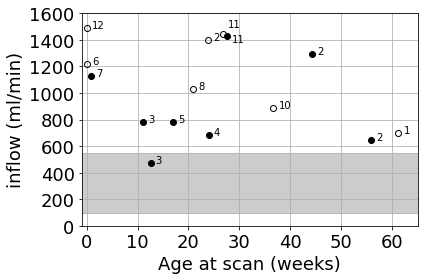

In [5]:
##### Figure 3a
# Inflow versus GA. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# plt.plot(T['age_at_scan_weeks'], T['inflow_ml/min'], 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'inflow_ml/min'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'inflow_ml/min'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow (ml/min)', fontsize=18)
plt.ylim([0, 1600])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
ax = plt.gca()
ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i]+0.1)))
    
for i, x in enumerate(T['ID_N']):
    if x != 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])))
for i, x in enumerate(T['ID_N']):
    if x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])+50))
    if x == 11 and i == 12:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, (T['inflow_ml/min'][i])-50))

fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig3a.png')  

In [6]:
# Helper function to format the statmodels output for direct copy into the results table
def format_result(result):
    output = ""
    for name in result.model.exog_names:
        coef = result.params.loc[name] # Get the coefficient estimate
        lower = result.conf_int().loc[name, 0] # Get the lower limit of the confidence interval
        upper = result.conf_int().loc[name, 1] # Get the upper limit of the confidence interval
        pvalue = result.pvalues.loc[name] # Get the p-value
        # Format the output as "name: coef [lower, upper] pvalue ="
        output += f"{name}: {coef:.0f} [{lower:.0f}, {upper:.0f}] P={pvalue:.3f}\n"
    SW = scipy.stats.shapiro(result.resid)
    output += f"W={SW.statistic:.2f}, P={SW.pvalue:.3f}"
    return output

                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.010
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.332
Time:                        15:24:04   Log-Likelihood:                -118.16
No. Observations:                  16   AIC:                             240.3
Df Residuals:                      14   BIC:                             241.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1230.1925    174.59

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


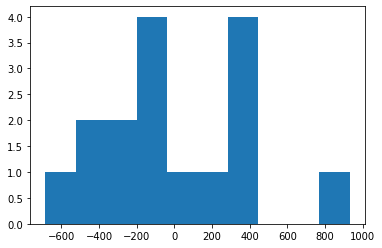

Intercept: 1230 [856, 1605] P=0.000
age_at_scan_weeks: -6 [-18, 7] P=0.332
W=0.95, P=0.571
                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.528
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.118
Time:                        15:24:05   Log-Likelihood:                -116.09
No. Observations:                  16   AIC:                             238.2
Df Residuals:                      13   BIC:                             240.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


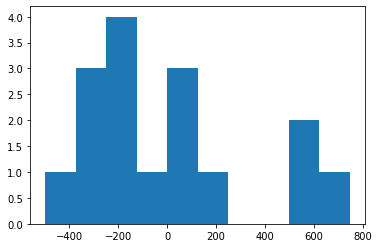

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 1413 [1014, 1811] P=0.000
age_at_scan_weeks: -6 [-17, 6] P=0.303
embo: -373 [-783, 38] P=0.072
W=0.93, P=0.207
                            OLS Regression Results                            
Dep. Variable:          inflow_ml_min   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1.557
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.251
Time:                        15:24:05   Log-Likelihood:                -116.09
No. Observations:                  16   AIC:                             240.2
Df Residuals:                      12   BIC:                             243.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--

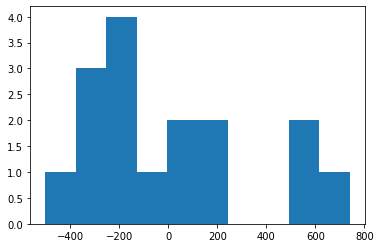

Intercept: 1422 [827, 2017] P=0.000
age_at_scan_weeks: -6 [-22, 10] P=0.428
embo: -374 [-814, 65] P=0.088
NAR: -16 [-746, 714] P=0.963
W=0.93, P=0.212


In [7]:
# Inflow models for paper
T['inflow_ml_min'] = T['inflow_ml/min']
mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="inflow_ml_min ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

In [8]:
# What is cortical flow? something like the inflow - varix flow
T['cortical_flow'] = (T['Inflow'] - T['falcine'])*60
# Or it could be SSS flow before the falcine drainage
T['SSS_mlmin'] = T['SSS'] * 60

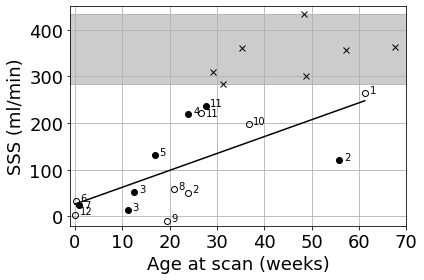

In [9]:
## SSS versus GA. Fig 2d

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'SSS_mlmin'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'SSS_mlmin'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('SSS (ml/min)', fontsize=18)
plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# Trendline
T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
f = np.poly1d(d)
plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
plt.plot(plot_x, f(plot_x), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['SSS_mlmin'][i]))

# SSS from Can Wu
sss_data = pd.read_excel('/home/jeff/jeff.stout/research/clinical_cases/ISMRM2023/Vessel Blood Flow Can Wu 2017.xlsx', header=3)
plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
plt.xlim([-1, 70])
plt.ylim([-20, 450])
ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2d.png')

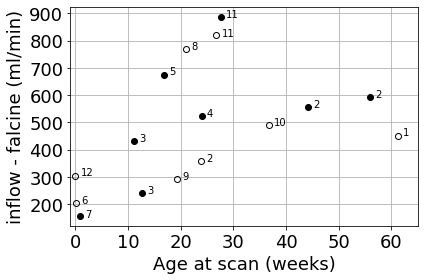

In [10]:
## Inflow-flacine versus GA. fig 2c

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'cortical_flow'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'cortical_flow'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('inflow - falcine (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['cortical_flow'], 1)
# f = np.poly1d(d)
# plt.plot(T_nan['age_at_scan_weeks'], f(T_nan['age_at_scan_weeks']), 'k-')

ax = plt.gca()
# ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if x == 7: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]-6))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['cortical_flow'][i]))

        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2c.png')

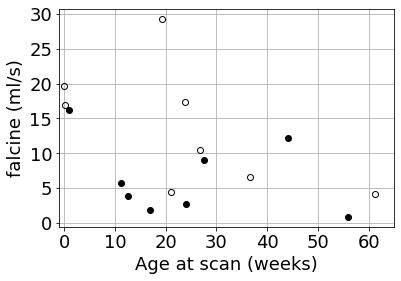

In [11]:
## Inflow-flacine versus GA

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'falcine'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'falcine'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('falcine (ml/s)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()


                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     11.52
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00436
Time:                        15:49:57   Log-Likelihood:                -116.07
No. Observations:                  16   AIC:                             236.1
Df Residuals:                      14   BIC:                             237.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -186.3894    250.380     -0.744      0.4

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


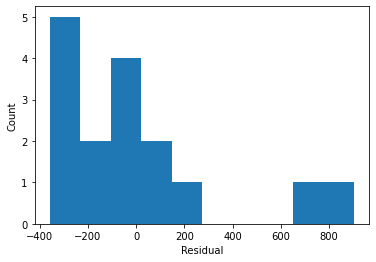

Intercept: -186.39 [-723.40, 350.62] P=0.469
SSMD: 146.12 [53.80, 238.44] P=0.004
W=0.78, P=0.002
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     11.92
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00115
Time:                        15:49:57   Log-Likelihood:                -112.54
No. Observations:                  16   AIC:                             231.1
Df Residuals:                      13   BIC:                             233.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


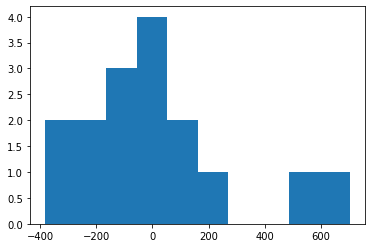

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 28.74 [-453.65, 511.13] P=0.900
SSMD: 144.14 [66.72, 221.56] P=0.001
embo: -408.81 [-737.82, -79.80] P=0.019
W=0.89, P=0.055
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     7.616
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00410
Time:                        15:49:57   Log-Likelihood:                -112.35
No. Observations:                  16   AIC:                             232.7
Df Residuals:                      12   BIC:                             235.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

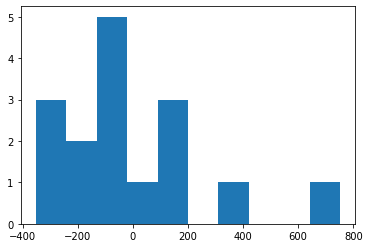

Intercept: 58.02 [-455.68, 571.71] P=0.810
SSMD: 132.97 [41.13, 224.81] P=0.008
embo: -393.94 [-740.24, -47.65] P=0.029
NAR: 126.79 [-379.62, 633.21] P=0.595
W=0.90, P=0.068
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     3.190
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0958
Time:                        15:49:57   Log-Likelihood:                -119.23
No. Observations:                  16   AIC:                             242.5
Df Residuals:                      14   BIC:                             244.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std 

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


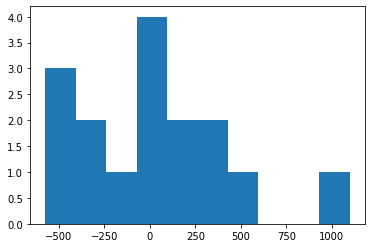

Intercept: 872.32 [471.93, 1272.71] P=0.000
age_at_scan_weeks: -11.20 [-24.65, 2.25] P=0.096
W=0.93, P=0.247
                            OLS Regression Results                            
Dep. Variable:          falcine_mlmin   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     4.118
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0412
Time:                        15:49:57   Log-Likelihood:                -116.95
No. Observations:                  16   AIC:                             239.9
Df Residuals:                      13   BIC:                             242.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


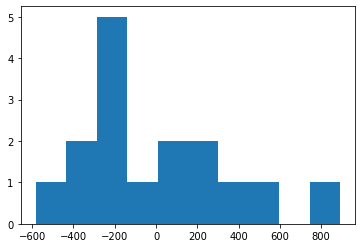

Intercept: 1076.03 [655.60, 1496.46] P=0.000
age_at_scan_weeks: -11.03 [-23.22, 1.16] P=0.073
embo: -415.65 [-848.94, 17.64] P=0.059
W=0.95, P=0.417


In [29]:
# Falcine models

T['falcine_mlmin'] = T['falcine'] * 60

mod = smf.ols(formula="falcine_mlmin ~ SSMD", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ SSMD + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin ~ age_at_scan_weeks +embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

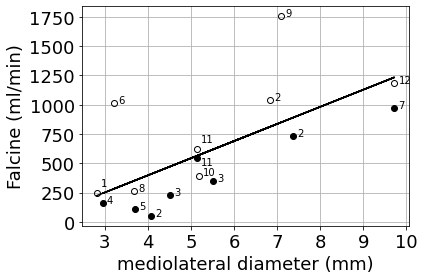

In [13]:
### Figure 2b (raw flow)
# Falcince:Inflow versus SS-MD. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# abstract style, all solid
# plt.plot(T['SS-MD'], T['falcine']*60, 'ko')

# # No red/black for NAR, ALL Black
# # No NAR is black
# plt.plot(T.loc[(T['embo']==0) , 'SS-MD'], T.loc[(T['embo']==0) , 'falcine']*60, 'ko', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) , 'SS-MD'], T.loc[(T['embo']==1) , 'falcine']*60, 'ko')

# No NAR is black
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==0), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==0), 'falcine']*60, 'ko')
# NAR is red
# plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ro', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ro')
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ko')

plt.xlabel('mediolateral diameter (mm)', fontsize=18)
plt.ylabel('Falcine (ml/min)', fontsize=18)
# plt.ylim([0, 300])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
d = np.polyfit(T['SS-MD'], T['falcine']*60, 1)
f = np.poly1d(d)
plt.plot(T['SS-MD'], f(T['SS-MD']), 'k-')
 
for i, x in enumerate(T['ID_N']):
    if i == 0:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 11:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]+1)*60))
    elif i == 12:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine'][i]-1)*60))
    else:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, T['falcine'][i]*60))

# # M.W. second time point
# plt.plot(4.52, 3.8, 'ko', fillstyle='none')
# plt.annotate('3', (4.52+0.1, 3.8+0.1))

fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig2d.png')

                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     12.28
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00351
Time:                        15:24:06   Log-Likelihood:                -18.061
No. Observations:                  16   AIC:                             40.12
Df Residuals:                      14   BIC:                             41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8664      0.547      5.237      0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


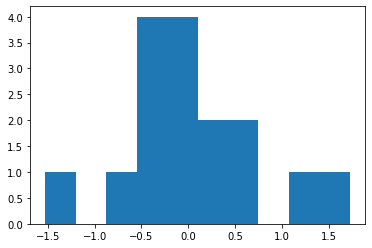

Intercept: 2.87 [1.69, 4.04] P=0.000
SSMD: 0.33 [0.13, 0.53] P=0.004
W=0.96, P=0.575
                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     13.80
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           0.000610
Time:                        15:24:06   Log-Likelihood:                -13.987
No. Observations:                  16   AIC:                             33.97
Df Residuals:                      13   BIC:                             36.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


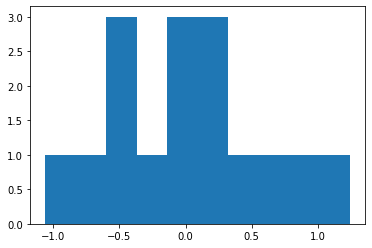

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 3.36 [2.34, 4.38] P=0.000
SSMD: 0.33 [0.16, 0.49] P=0.001
embo: -0.95 [-1.64, -0.25] P=0.012
W=0.98, P=0.920
                            OLS Regression Results                            
Dep. Variable:     falcine_mlmin_root   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     8.947
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00219
Time:                        15:24:06   Log-Likelihood:                -13.701
No. Observations:                  16   AIC:                             35.40
Df Residuals:                      12   BIC:                             38.49
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

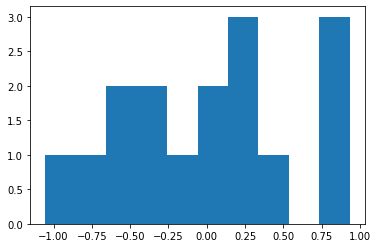

Intercept: 3.44 [2.36, 4.52] P=0.000
SSMD: 0.30 [0.10, 0.49] P=0.006
embo: -0.91 [-1.64, -0.18] P=0.019
NAR: 0.32 [-0.74, 1.39] P=0.522
W=0.97, P=0.778


In [14]:
# Falcine models
# fourth root

# Helper function to format the statmodels output for direct copy into the results table
def format_result(result):
    output = ""
    for name in result.model.exog_names:
        coef = result.params.loc[name] # Get the coefficient estimate
        lower = result.conf_int().loc[name, 0] # Get the lower limit of the confidence interval
        upper = result.conf_int().loc[name, 1] # Get the upper limit of the confidence interval
        pvalue = result.pvalues.loc[name] # Get the p-value
        # Format the output as "name: coef [lower, upper] pvalue ="
        output += f"{name}: {coef:.2f} [{lower:.2f}, {upper:.2f}] P={pvalue:.3f}\n"
    SW = scipy.stats.shapiro(result.resid)
    output += f"W={SW.statistic:.2f}, P={SW.pvalue:.3f}"
    return output


T['falcine_mlmin_root'] = (T['falcine'] * 60) ** (1/4)

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="falcine_mlmin_root ~ SSMD + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

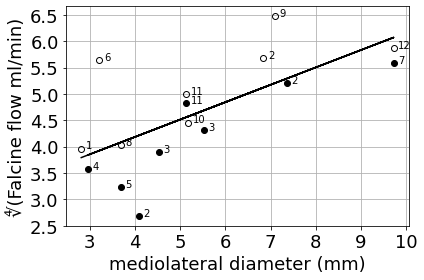

In [30]:
### Figure 2b
# Falcince:Inflow versus SS-MD. This is really abnormal
# So this is an interesting plot when compared with the normal data that goes from 100ml/min at birth to 550ml/min at 60 weeks (ref: Varela, Liu)
# abstract style, all solid
# plt.plot(T['SS-MD'], T['falcine']*60, 'ko')

# # No red/black for NAR, ALL Black
# # No NAR is black
# plt.plot(T.loc[(T['embo']==0) , 'SS-MD'], T.loc[(T['embo']==0) , 'falcine']*60, 'ko', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) , 'SS-MD'], T.loc[(T['embo']==1) , 'falcine']*60, 'ko')

# No NAR is black
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==0), 'falcine_mlmin_root'], 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==0), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==0), 'falcine_mlmin_root'], 'ko')
# NAR is red
# plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine']*60, 'ro', fillstyle='none',)
# plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine']*60, 'ro')
plt.plot(T.loc[(T['embo']==0) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==0) & (T['NAR']==1), 'falcine_mlmin_root'], 'ko', fillstyle='none',)
plt.plot(T.loc[(T['embo']==1) & (T['NAR']==1), 'SS-MD'], T.loc[(T['embo']==1) & (T['NAR']==1), 'falcine_mlmin_root'], 'ko')

plt.xlabel('mediolateral diameter (mm)', fontsize=18)
plt.ylabel('\u221C(Falcine flow ml/min)', fontsize=18)
# plt.ylim([0, 300])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
d = np.polyfit(T['SS-MD'], T['falcine_mlmin_root'], 1)
f = np.poly1d(d)
plt.plot(T['SS-MD'], f(T['SS-MD']), 'k-')
 
for i, x in enumerate(T['ID_N']):
    if i == 0:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    elif i == 11:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    elif i == 12:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, (T['falcine_mlmin_root'][i])))
    else:
        plt.annotate('%i' % x, (T['SS-MD'][i]+.1, T['falcine_mlmin_root'][i]))

# # M.W. second time point
# plt.plot(4.52, 3.8, 'ko', fillstyle='none')
# plt.annotate('3', (4.52+0.1, 3.8+0.1))

fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig2b.png')

                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     3.303
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0906
Time:                        15:39:04   Log-Likelihood:                -107.00
No. Observations:                  16   AIC:                             218.0
Df Residuals:                      14   BIC:                             219.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           357.8714     86.89

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


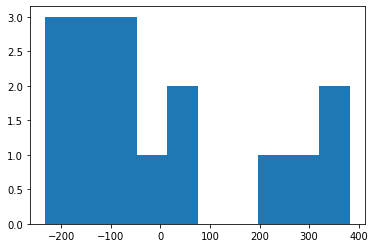

Intercept: 357.87 [171.49, 544.25] P=0.001
age_at_scan_weeks: 5.31 [-0.96, 11.57] P=0.091
W=0.87, P=0.032
                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1.634
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.233
Time:                        15:39:05   Log-Likelihood:                -106.90
No. Observations:                  16   AIC:                             219.8
Df Residuals:                      13   BIC:                             222.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


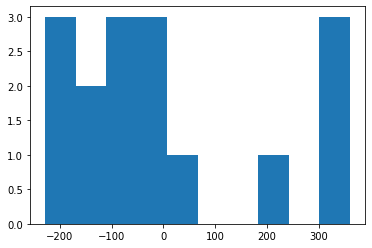

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 336.73 [112.40, 561.07] P=0.006
age_at_scan_weeks: 5.29 [-1.22, 11.79] P=0.103
embo: 43.13 [-188.07, 274.33] P=0.693
W=0.86, P=0.019
                            OLS Regression Results                            
Dep. Variable:          cortical_flow   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     2.151
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.147
Time:                        15:39:05   Log-Likelihood:                -105.25
No. Observations:                  16   AIC:                             218.5
Df Residuals:                      12   BIC:                             221.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|     

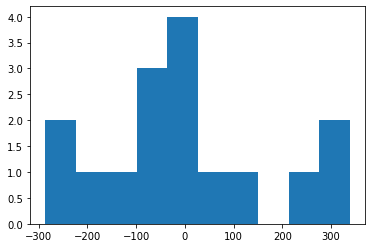

Intercept: 499.99 [198.00, 801.97] P=0.004
age_at_scan_weeks: 1.36 [-6.68, 9.40] P=0.719
embo: 9.94 [-213.29, 233.18] P=0.924
NAR: -281.96 [-652.67, 88.75] P=0.123
W=0.96, P=0.623


In [27]:
## A bit more about cortical flow:
mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))


mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="cortical_flow ~ age_at_scan_weeks + embo + NAR", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     11.38
Date:                Mon, 23 Oct 2023   Prob (F-statistic):            0.00499
Time:                        15:24:06   Log-Likelihood:                -84.530
No. Observations:                  15   AIC:                             173.1
Df Residuals:                      13   BIC:                             174.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            26.3734     30.60

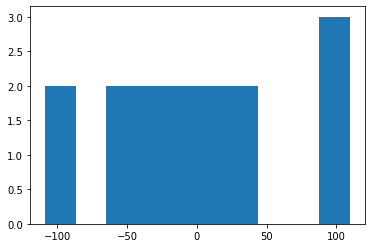

Intercept: 26.37 [-39.75, 92.50] P=0.404
age_at_scan_weeks: 3.62 [1.30, 5.93] P=0.005
W=0.95, P=0.527
                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     5.494
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0202
Time:                        15:24:06   Log-Likelihood:                -84.370
No. Observations:                  15   AIC:                             174.7
Df Residuals:                      12   BIC:                             176.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


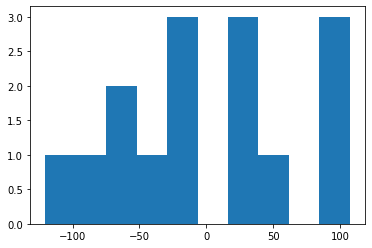

Intercept: 16.29 [-64.82, 97.41] P=0.669
age_at_scan_weeks: 3.65 [1.24, 6.07] P=0.006
embo: 19.79 [-64.96, 104.53] P=0.620
W=0.97, P=0.782
                            OLS Regression Results                            
Dep. Variable:              SSS_mlmin   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     3.366
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0586
Time:                        15:24:06   Log-Likelihood:                -84.361
No. Observations:                  15   AIC:                             176.7
Df Residuals:                      11   BIC:                             179.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


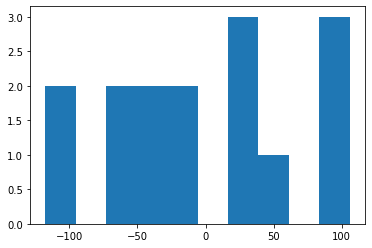

Intercept: 20.92 [-101.85, 143.69] P=0.715
age_at_scan_weeks: 3.54 [0.20, 6.88] P=0.040
embo: 18.69 [-73.08, 110.46] P=0.663
NAR: -7.74 [-155.21, 139.73] P=0.910
W=0.96, P=0.733


In [17]:
## SSS 
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

## So relating falcine flow to SSMD including a categorical effect of embolizaiton works really well without Labady, and with him still looks alright
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

## Probably a stretch, but nearly significant
mod = smf.ols(formula="SSS_mlmin ~ age_at_scan_weeks + embo + NAR", data=T) # And embo is not significant (Does that make sense?)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))



In [18]:
## I would really like to know how the MCA/PCA ratio looks

In [19]:
# Now that you have PCA flows, calc the ratio
T.keys()
T['R_PCAMCA'] = T['RPCA'] / T['RMCA']
T['L_PCAMCA'] = T['LPCA'] / T['LMCA']

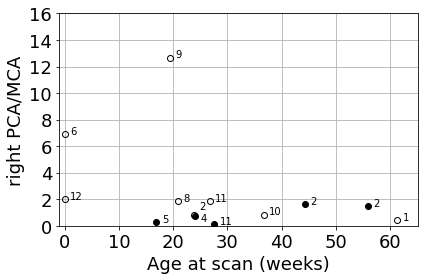

In [20]:
## RPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'R_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 16])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 1: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] + 0.4))
    elif i == 4: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i] - 0.4))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['R_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_rmcamca.png')

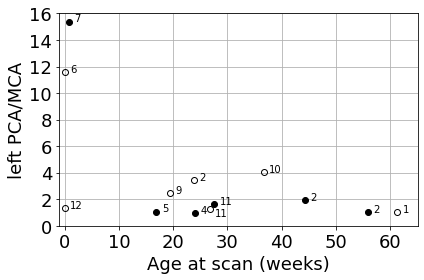

In [21]:
## LPCMCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'L_PCAMCA'], 'ko')
plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 16])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# for i, x in enumerate(T['SS-MD']):
#     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
for i, x in enumerate(T['ID_N']):
    if i == 11: # move it down a bit
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
    elif x == 11 and i == 11:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
    else:
        plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_lmcamca.png')

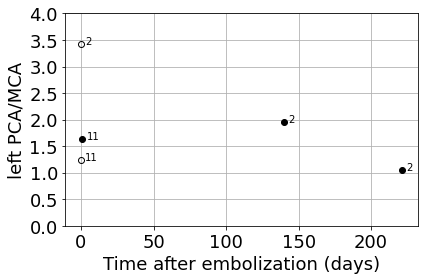

In [22]:
### PCA/MCA versus time after embo

# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'L_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'L_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('left PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['L_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_embolizationtimeLmcamca.png')

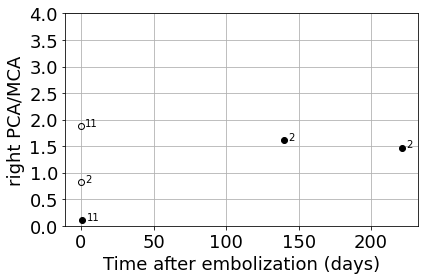

In [23]:
# Falcine versus day of embo.
# So this is an interesting plot when compared with Wu et al. 2016

T_plot = T.loc[(T['ID_N']==2) | (T['ID_N']==11)].reset_index(drop=True)

plt.plot(T_plot.loc[T_plot['embo']==0, 'embo_time_days'], T_plot.loc[T_plot['embo']==0, 'R_PCAMCA'], 'ko', fillstyle='none',)
plt.plot(T_plot.loc[T_plot['embo']==1, 'embo_time_days'], T_plot.loc[T_plot['embo']==1, 'R_PCAMCA'], 'ko')

plt.xlabel('Time after embolization (days)', fontsize=18)
plt.ylabel('right PCA/MCA', fontsize=18)
plt.ylim([0, 4])
# plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis="both")

ax1 = plt.gca()
for i, x in enumerate(T_plot['ID_N']):
    ax1.annotate('%i' % x, (T_plot['embo_time_days'][i]+3, (T_plot['R_PCAMCA'][i])))


fig = plt.gcf()
plt.tight_layout()
fig.savefig('fig_embolizationtimeRmcamca.png')

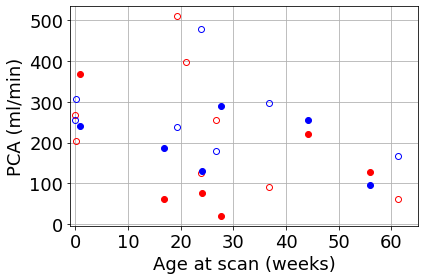

In [24]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RPCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RPCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LPCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LPCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('PCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig_pacaVage.png')

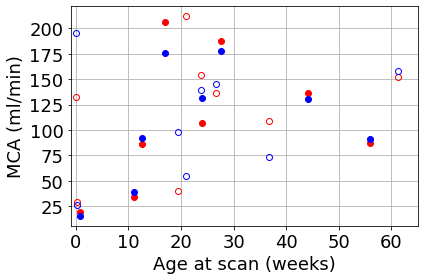

In [25]:
## PCA versus GA. 

# plt.plot(T['age_at_scan_weeks'], T['SSS']*60, 'ko')
plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'RMCA']*60, 'ro', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'RMCA']*60, 'ro')

plt.plot(T.loc[T['embo']==0, 'age_at_scan_weeks'], T.loc[T['embo']==0, 'LMCA']*60, 'bo', fillstyle='none',)
plt.plot(T.loc[T['embo']==1, 'age_at_scan_weeks'], T.loc[T['embo']==1, 'LMCA']*60, 'bo')

plt.xlabel('Age at scan (weeks)', fontsize=18)
plt.ylabel('MCA (ml/min)', fontsize=18)
# plt.ylim([-20, 300])
plt.xlim([-1, 65])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# # Trendline
# T_nan = T.dropna(subset=['SSS']) # This wasn't plotting, becasue of nan in the SSS column
# d = np.polyfit(T_nan['age_at_scan_weeks'], T_nan['SSS_mlmin'], 1)
# f = np.poly1d(d)
# plot_x = [np.min(T_nan['age_at_scan_weeks']), np.max(T_nan['age_at_scan_weeks'])]
# plt.plot(plot_x, f(plot_x), 'k-')

# ax = plt.gca()
# # ax.axhspan(100, 550, xmin=0, xmax=1, alpha=0.2, color='black')

# # for i, x in enumerate(T['SS-MD']):
# #     plt.annotate('%i' % (i+1), (T['age_at_scan_weeks'][i]+1, (T['SSS'][i]+0.1)*60))
# for i, x in enumerate(T['ID_N']):
#     if i == 11: # move it down a bit
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]-0.5))
#     elif x == 11 and i == 11:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))
#     else:
#         plt.annotate('%i' % x, (T['age_at_scan_weeks'][i]+1, T['L_PCAMCA'][i]))

# # SSS from Can Wu
# sss_data = pd.read_excel('Vessel Blood Flow Can Wu 2017.xlsx', header=3)
# # plt.plot(52 * sss_data.loc[sss_data['Age [Y]']<1.6, 'Age [Y]'], 60 * sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'], 'kx')
# # plt.xlim([-1, 70])
# plt.ylim([-20, 450])
# ax.axhspan(np.min(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, np.max(sss_data.loc[sss_data['Age [Y]']<1.6, 'SSS'])*60, alpha=0.2, color='black')
        
fig = plt.gcf()
plt.tight_layout()
# fig.savefig('fig_mcaVage.png')

                            OLS Regression Results                            
Dep. Variable:               R_PCAMCA   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     3.996
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0688
Time:                        15:24:07   Log-Likelihood:                -41.185
No. Observations:                  14   AIC:                             86.37
Df Residuals:                      12   BIC:                             87.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.2779      2.27

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


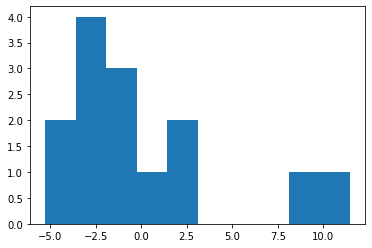

Intercept: 7.28 [2.33, 12.23] P=0.008
age_at_scan_weeks: -0.14 [-0.30, 0.01] P=0.069
W=0.86, P=0.027
                            OLS Regression Results                            
Dep. Variable:               R_PCAMCA   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1.927
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.192
Time:                        15:24:07   Log-Likelihood:                -41.094
No. Observations:                  14   AIC:                             88.19
Df Residuals:                      11   BIC:                             90.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


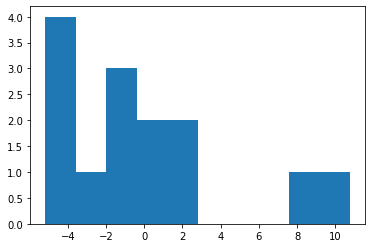

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Intercept: 6.92 [1.32, 12.52] P=0.020
age_at_scan_weeks: -0.15 [-0.31, 0.02] P=0.076
embo: 1.06 [-5.10, 7.21] P=0.713
W=0.87, P=0.040
                            OLS Regression Results                            
Dep. Variable:               L_PCAMCA   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     4.994
Date:                Mon, 23 Oct 2023   Prob (F-statistic):             0.0471
Time:                        15:24:07   Log-Likelihood:                -35.178
No. Observations:                  13   AIC:                             74.36
Df Residuals:                      11   BIC:                             75.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025   

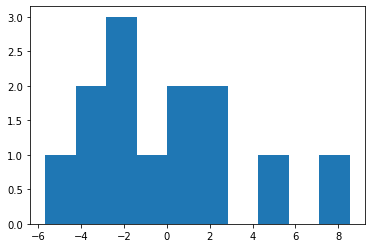

Intercept: 6.96 [2.89, 11.03] P=0.003
age_at_scan_weeks: -0.13 [-0.25, -0.00] P=0.047
W=0.95, P=0.646
                            OLS Regression Results                            
Dep. Variable:               L_PCAMCA   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2.328
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.148
Time:                        15:24:07   Log-Likelihood:                -35.127
No. Observations:                  13   AIC:                             76.25
Df Residuals:                      10   BIC:                             77.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


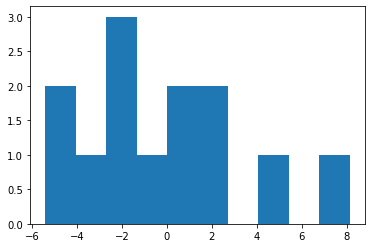

Intercept: 6.71 [1.98, 11.45] P=0.010
age_at_scan_weeks: -0.13 [-0.26, 0.00] P=0.056
embo: 0.65 [-4.48, 5.78] P=0.784
W=0.96, P=0.769
                            OLS Regression Results                            
Dep. Variable:             LMCA_mlmin   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.289
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.275
Time:                        15:24:08   Log-Likelihood:                -85.993
No. Observations:                  16   AIC:                             176.0
Df Residuals:                      14   BIC:                             177.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025   

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


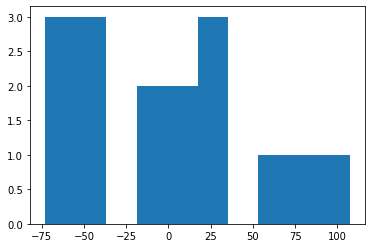

Intercept: 87.68 [37.53, 137.82] P=0.002
age_at_scan_weeks: 0.89 [-0.79, 2.58] P=0.275
W=0.94, P=0.394
                            OLS Regression Results                            
Dep. Variable:             LMCA_mlmin   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.054
Method:                 Least Squares   F-statistic:                    0.6157
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.555
Time:                        15:24:08   Log-Likelihood:                -85.974
No. Observations:                  16   AIC:                             177.9
Df Residuals:                      13   BIC:                             180.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


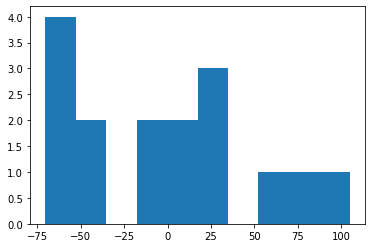

Intercept: 90.18 [29.52, 150.85] P=0.007
age_at_scan_weeks: 0.89 [-0.87, 2.65] P=0.292
embo: -5.12 [-67.64, 57.40] P=0.862
W=0.94, P=0.316
                            OLS Regression Results                            
Dep. Variable:             RMCA_mlmin   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.814
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.199
Time:                        15:24:08   Log-Likelihood:                -87.193
No. Observations:                  16   AIC:                             178.4
Df Residuals:                      14   BIC:                             179.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.0

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


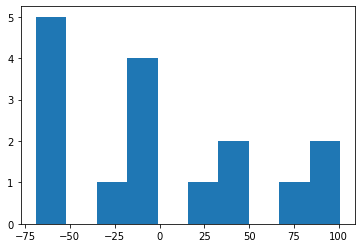

Intercept: 87.14 [33.09, 141.20] P=0.004
age_at_scan_weeks: 1.14 [-0.68, 2.96] P=0.199
W=0.91, P=0.127
                            OLS Regression Results                            
Dep. Variable:             RMCA_mlmin   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9399
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.416
Time:                        15:24:08   Log-Likelihood:                -87.087
No. Observations:                  16   AIC:                             180.2
Df Residuals:                      13   BIC:                             182.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


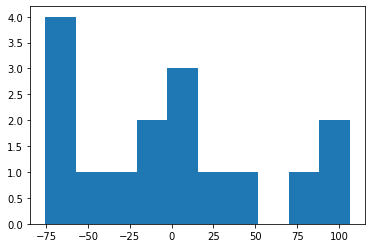

Intercept: 93.47 [28.43, 158.50] P=0.008
age_at_scan_weeks: 1.15 [-0.74, 3.03] P=0.212
embo: -12.90 [-79.93, 54.13] P=0.684
W=0.93, P=0.255
                            OLS Regression Results                            
Dep. Variable:             LPCA_mlmin   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.472
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.250
Time:                        15:24:08   Log-Likelihood:                -76.571
No. Observations:                  13   AIC:                             157.1
Df Residuals:                      11   BIC:                             158.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


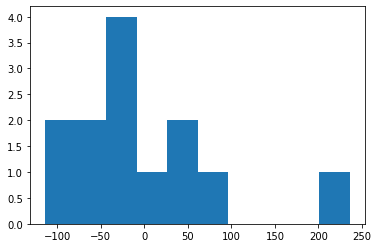

Intercept: 283.59 [185.36, 381.82] P=0.000
age_at_scan_weeks: -1.68 [-4.74, 1.37] P=0.250
W=0.90, P=0.115
                            OLS Regression Results                            
Dep. Variable:             LPCA_mlmin   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1.663
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.238
Time:                        15:24:08   Log-Likelihood:                -75.521
No. Observations:                  13   AIC:                             157.0
Df Residuals:                      10   BIC:                             158.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


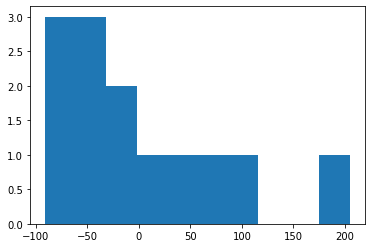

Intercept: 309.89 [203.99, 415.79] P=0.000
age_at_scan_weeks: -1.48 [-4.49, 1.52] P=0.297
embo: -68.17 [-182.90, 46.55] P=0.215
W=0.88, P=0.065
                            OLS Regression Results                            
Dep. Variable:             RPCA_mlmin   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2.675
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.128
Time:                        15:24:08   Log-Likelihood:                -87.755
No. Observations:                  14   AIC:                             179.5
Df Residuals:                      12   BIC:                             180.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|     

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


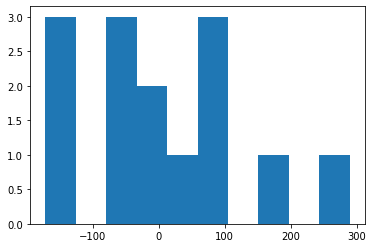

Intercept: 283.18 [145.44, 420.93] P=0.001
age_at_scan_weeks: -3.28 [-7.65, 1.09] P=0.128
W=0.95, P=0.532
                            OLS Regression Results                            
Dep. Variable:             RPCA_mlmin   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1.909
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.194
Time:                        15:24:08   Log-Likelihood:                -87.078
No. Observations:                  14   AIC:                             180.2
Df Residuals:                      11   BIC:                             182.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/jeff/virtualenv/jupyterlab3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


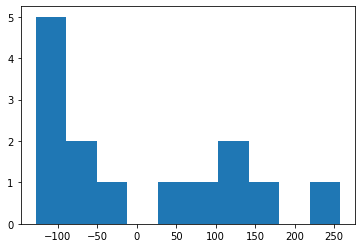

Intercept: 310.23 [160.74, 459.71] P=0.001
age_at_scan_weeks: -3.02 [-7.45, 1.41] P=0.162
embo: -78.93 [-243.30, 85.45] P=0.313
W=0.87, P=0.042


In [26]:
## For Table 2
T['LMCA_mlmin'] = T['LMCA'] * 60
T['RMCA_mlmin'] = T['RMCA'] * 60
T['LPCA_mlmin'] = T['LPCA'] * 60
T['RPCA_mlmin'] = T['RPCA'] * 60

mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="R_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="L_PCAMCA ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="LMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="RMCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="LPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))

mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))
mod = smf.ols(formula="RPCA_mlmin ~ age_at_scan_weeks + embo", data=T)
res = mod.fit()
print(res.summary())
plt.hist(res.resid)
plt.show()
print(format_result(res))